# Modèle de reconnaissance d'empreintes

In [341]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from keras import layers
from random import shuffle

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [342]:
# Construire le dataset à partir du folder 

image_size = (128, 128)
batch_size = 64
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "/home/shared/Dataset_wildlens",
    validation_split=0.2,
    subset="both",
    seed=1,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="rgb"
)

Found 508 files belonging to 2 classes.
Using 407 files for training.
Using 101 files for validation.


In [343]:
len(train_ds)

7

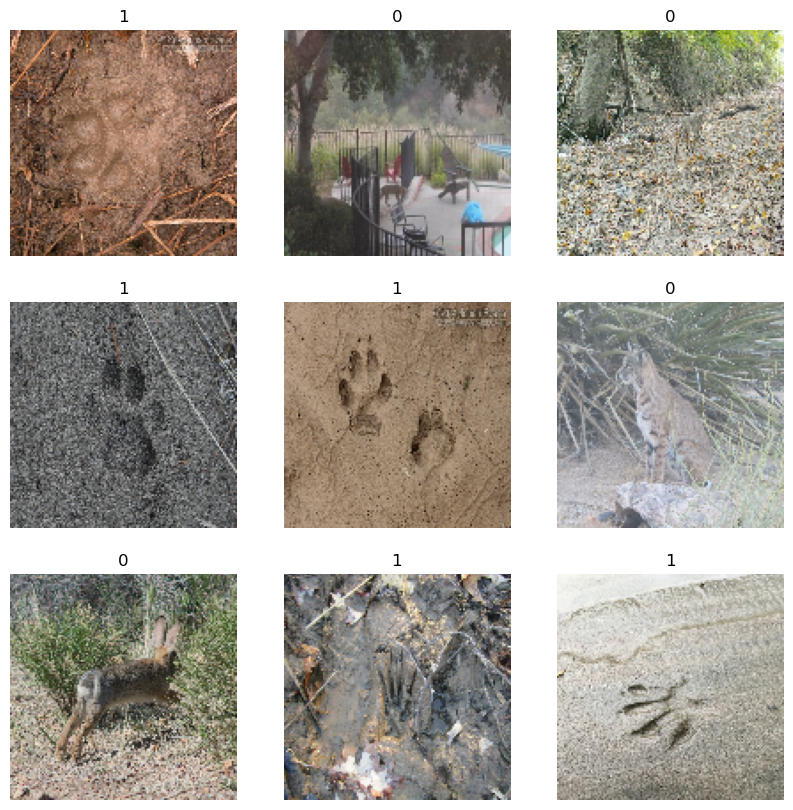

In [344]:
# Voir les 9 premières images

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(min(9, batch_size)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [345]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

In [346]:
"""binary_model = tf.keras.Sequential([
    data_augmentation,
    layers.Grayscale(),
    layers.Rescaling(1./255),

    layers.Normalization(
        mean=np.array([0.485, 0.456, 0.406]),
        variance=np.array([0.229, 0.224, 0.225])
    ),

    layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.6),
    layers.Dense(1, activation='sigmoid')
])"""

"binary_model = tf.keras.Sequential([\n    data_augmentation,\n    layers.Grayscale(),\n    layers.Rescaling(1./255),\n\n    layers.Normalization(\n        mean=np.array([0.485, 0.456, 0.406]),\n        variance=np.array([0.229, 0.224, 0.225])\n    ),\n\n    layers.Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),\n    layers.BatchNormalization(),\n    layers.MaxPooling2D(pool_size=(2, 2)),\n    layers.Dropout(0.2),\n\n    layers.Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),\n    layers.BatchNormalization(),\n    layers.MaxPooling2D(pool_size=(2, 2)),\n    layers.Dropout(0.2),\n\n    layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),\n    layers.BatchNormalization(),\n    layers.MaxPooling2D(pool_size=(2, 2)),\n    layers.Dropout(0.3),\n\n    layers.Flatten(),\n    layers.Dense(64, activation='relu', kernel_regularizer=keras.regular

In [347]:
"""checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

binary_model.compile(
    optimizer=keras.optimizers.AdamW(1e-4),
    loss=tf.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)"""

"checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(\n    filepath='best_model.keras',\n    monitor='val_loss',\n    save_best_only=True,\n    verbose=1\n)\n\nbinary_model.compile(\n    optimizer=keras.optimizers.AdamW(1e-4),\n    loss=tf.losses.BinaryCrossentropy(from_logits=False),\n    metrics=['accuracy']\n)"

In [348]:

preprocessing_layer = tf.keras.Sequential([
    layers.Resizing(128, 128),
    layers.Rescaling(1./255),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

base_model = tf.keras.applications.MobileNetV2(input_shape=(128, 128, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    preprocessing_layer,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

In [349]:
model.compile(optimizer=keras.optimizers.AdamW(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [350]:
epochs = 40

hist = model.fit(
   train_ds,
   epochs=epochs,
   batch_size=batch_size,
   validation_data=val_ds,
)

Epoch 1/40


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4779 - loss: 1.5265 - val_accuracy: 0.4752 - val_loss: 0.9422
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5208 - loss: 1.0190 - val_accuracy: 0.4950 - val_loss: 0.7448
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5170 - loss: 0.8156 - val_accuracy: 0.5941 - val_loss: 0.6859
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5751 - loss: 0.7859 - val_accuracy: 0.6337 - val_loss: 0.6345
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6052 - loss: 0.7430 - val_accuracy: 0.7426 - val_loss: 0.5588
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6246 - loss: 0.6607 - val_accuracy: 0.7624 - val_loss: 0.4925
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6565 - loss: 0.6222 - val_accuracy: 0.8020 - val_loss: 0.4390
Epoch 8/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6543 - loss: 0.5972 - val_accuracy: 0.8416 - val_loss: 0.3960
Epoch 9/40

In [351]:
plt.figure(figsize=(8,8))

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

In [352]:
model.save('model.h5')

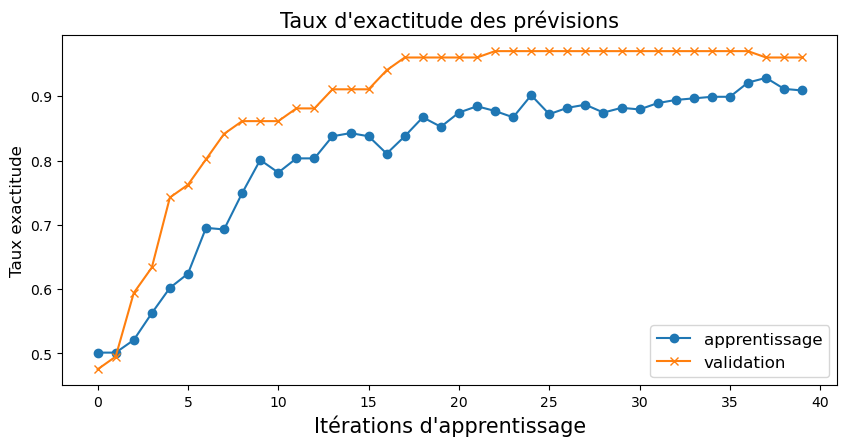

In [353]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(hist.history['accuracy'],'o-')
plt.plot(hist.history['val_accuracy'],'x-')
plt.title("Taux d'exactitude des prévisions",fontsize=15)
plt.ylabel('Taux exactitude',fontsize=12)
plt.xlabel("Itérations d'apprentissage",fontsize=15)
plt.legend(['apprentissage', 'validation'], loc='lower right',fontsize=12)

In [354]:
binary_model.predict

<bound method TensorFlowTrainer.predict of <Sequential name=sequential_26, built=True>>

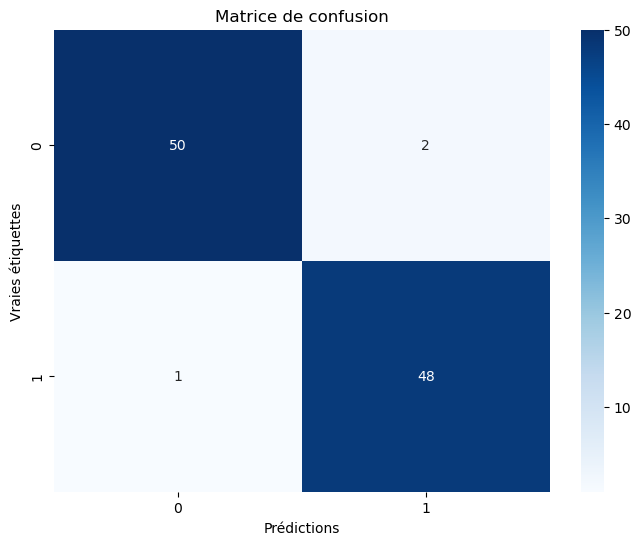

In [356]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


model = keras.models.load_model('model.keras')
# Get predictions for validation dataset
y_pred = []
y_true = []

for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    y_pred.extend((predictions > 0.5).astype(int).flatten())
    y_true.extend(labels.numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de confusion')
plt.ylabel('Vraies étiquettes')
plt.xlabel('Prédictions')
plt.show()

Faire :
- Un rollback + save best histoire de sauvegarder la meilleure version du modèle
- Un predict + matrice de confusion
